## Install the package dependencies before running this notebook

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import lstm_encoder_decoder_no_early

In [22]:
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import math

import gc
import os, os.path 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import time

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- val: 55029 test:7971
    # pittsburgh -- val: 43544 test: 6361
    # dearborn -- val: 24465 test: 3671
    # washington-dc -- val: 25744 test: 3829
    # palo-alto -- val:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- val: 55029 test:7971\n    # pittsburgh -- val: 43544 test: 6361\n    # dearborn -- val: 24465 test: 3671\n    # washington-dc -- val: 25744 test: 3829\n    # palo-alto -- val:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [23]:
ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test", "val"] 

def get_city_trajectories(city="palo-alto", split="train", SEED=42):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        inputs = inputs[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        outputs = outputs[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        inputs = inputs[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        outputs = outputs[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = torch.zeros(n,60, 2).to(device)

    return inputs, outputs


class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 120)
        )
        
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn_pos_inputs = self.input_positions_centered
        self.nn_velo_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn_pos_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn_velo_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn_pos_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn_pos_inputs[idx], 
                self.nn_pos_outputs[idx], 
                self.nn_velo_inputs[idx], 
                self.nn_velo_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx]
            )
        else:
            data = data = (
                self.nn_pos_inputs[idx], 
                self.nn_velo_inputs[idx], 
                self.center[idx]
            )
        return data

In [24]:
!nvidia-smi

Sat May 28 23:04:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 65%   47C    P5    37W / 370W |   8734MiB / 12288MiB |     56%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
# function that tells how long training takes
def train_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs 

### Random shuffle with seed 42 & add attention

Training austin


 23%|██▎       | 23/100 [00:39<02:03,  1.60s/it, loss=0.13809] 

Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


 54%|█████▍    | 54/100 [01:29<01:14,  1.63s/it, loss=0.00188]

Epoch 00054: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 100/100 [02:45<00:00,  1.66s/it, loss=0.00013]


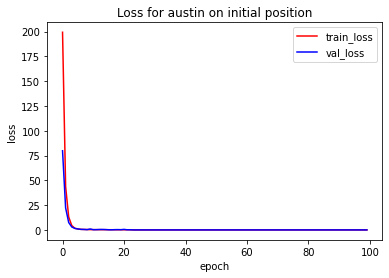

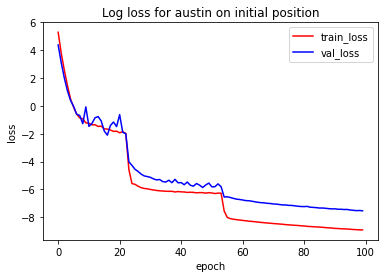

 70%|███████   | 84/120 [31:05<13:03, 21.76s/it, loss=0.00083]

Epoch 00084: reducing learning rate of group 0 to 1.0000e-05.


 82%|████████▏ | 98/120 [36:06<07:54, 21.57s/it, loss=0.00054]

Epoch 00098: reducing learning rate of group 0 to 1.0000e-06.


 82%|████████▎ | 99/120 [36:49<07:48, 22.32s/it, loss=0.00054]

Stopped early at epoch 99 due to overfit


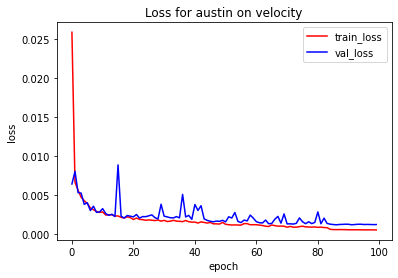

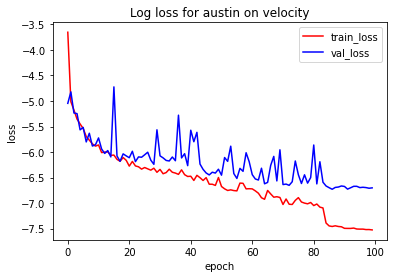

Total training time is: 39m 35s for austin
Training miami


 24%|██▍       | 24/100 [00:48<02:34,  2.03s/it, loss=0.08356] 

Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.


 47%|████▋     | 47/100 [01:35<01:46,  2.00s/it, loss=0.00117]

Epoch 00047: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 100/100 [03:23<00:00,  2.03s/it, loss=0.00008]


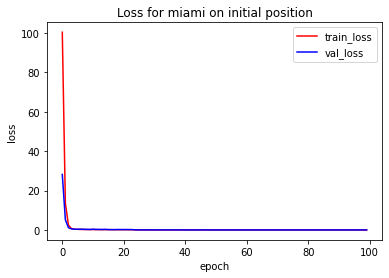

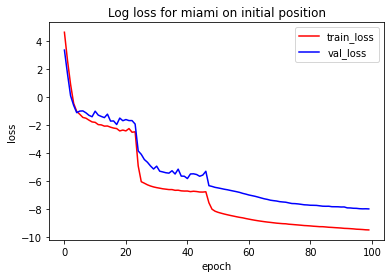

 55%|█████▌    | 66/120 [34:37<26:46, 29.74s/it, loss=0.00086]  

Epoch 00066: reducing learning rate of group 0 to 1.0000e-05.


 56%|█████▌    | 67/120 [35:38<28:11, 31.91s/it, loss=0.00066]

Stopped early at epoch 67 due to overfit


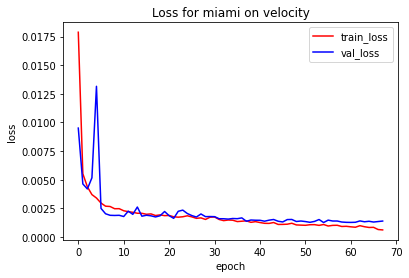

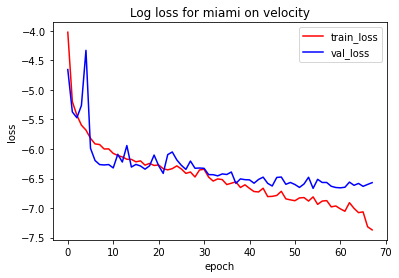

Total training time is: 39m 1s for miami
Training pittsburgh


 18%|█▊        | 18/100 [00:35<02:51,  2.10s/it, loss=0.11673] 

Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 55/100 [01:48<01:17,  1.72s/it, loss=0.00156]

Epoch 00055: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 100/100 [03:16<00:00,  1.97s/it, loss=0.00013]


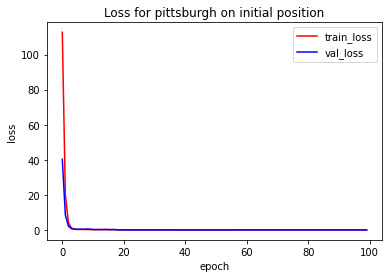

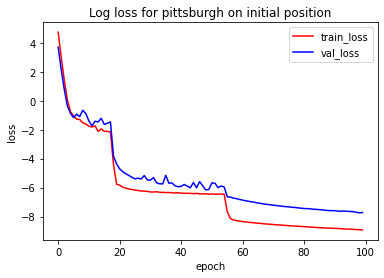

 56%|█████▌    | 67/120 [27:13<21:11, 24.00s/it, loss=0.00099]

Epoch 00067: reducing learning rate of group 0 to 1.0000e-05.


 57%|█████▋    | 68/120 [28:00<21:24, 24.71s/it, loss=0.00084]

Stopped early at epoch 68 due to overfit


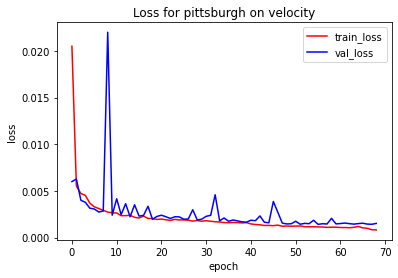

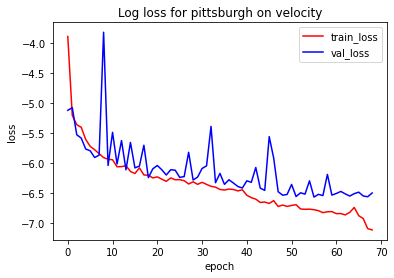

Total training time is: 31m 17s for pittsburgh
Training dearborn


 20%|██        | 20/100 [00:20<01:19,  1.00it/s, loss=0.28822] 

Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.


 34%|███▍      | 34/100 [00:37<01:27,  1.33s/it, loss=0.00489]

Epoch 00034: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 100/100 [01:54<00:00,  1.15s/it, loss=0.00017]


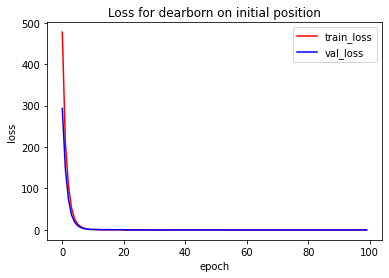

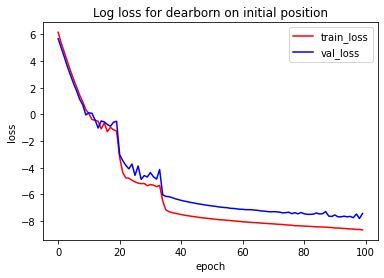

 42%|████▏     | 50/120 [11:23<16:51, 14.44s/it, loss=0.00208]

Epoch 00050: reducing learning rate of group 0 to 1.0000e-05.


 58%|█████▊    | 70/120 [16:02<12:01, 14.43s/it, loss=0.00124]

Epoch 00070: reducing learning rate of group 0 to 1.0000e-06.


 75%|███████▌  | 90/120 [20:38<06:53, 13.78s/it, loss=0.00120]

Epoch 00090: reducing learning rate of group 0 to 1.0000e-07.


 76%|███████▌  | 91/120 [21:06<06:43, 13.91s/it, loss=0.00119]

Stopped early at epoch 91 due to overfit


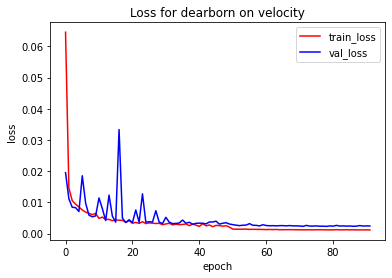

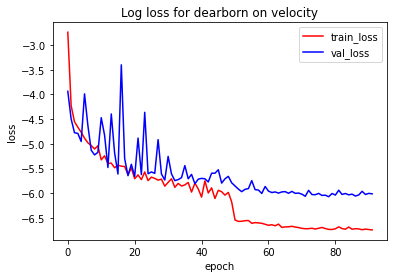

Total training time is: 23m 1s for dearborn
Training washington-dc


 31%|███       | 31/100 [00:34<01:09,  1.01s/it, loss=0.14147] 

Epoch 00031: reducing learning rate of group 0 to 1.0000e-04.


 67%|██████▋   | 67/100 [01:15<00:39,  1.18s/it, loss=0.00210]

Epoch 00067: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 100/100 [01:53<00:00,  1.13s/it, loss=0.00013]


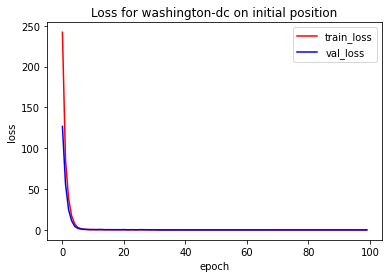

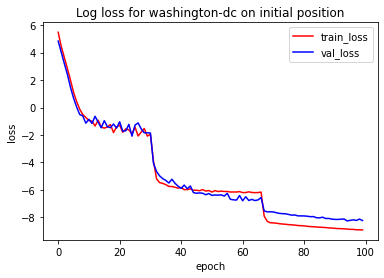

 33%|███▎      | 40/120 [09:04<17:46, 13.33s/it, loss=0.00204]

Epoch 00040: reducing learning rate of group 0 to 1.0000e-05.


 34%|███▍      | 41/120 [09:30<18:18, 13.91s/it, loss=0.00153]

Stopped early at epoch 41 due to overfit


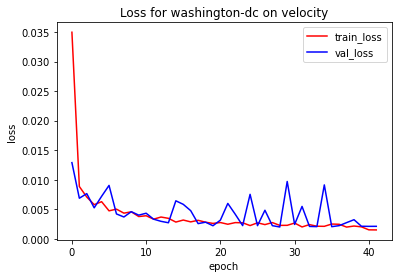

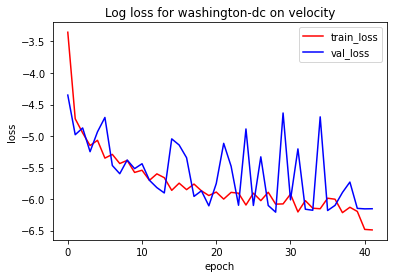

Total training time is: 11m 23s for washington-dc
Training palo-alto


 53%|█████▎    | 53/100 [00:26<00:25,  1.83it/s, loss=0.17367] 

Epoch 00053: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 100/100 [00:49<00:00,  2.02it/s, loss=0.00390]


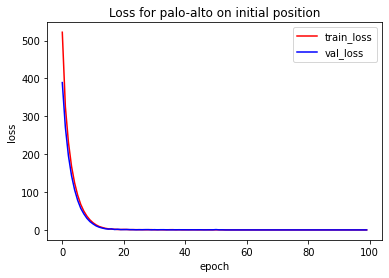

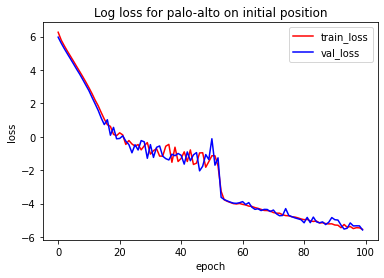

 52%|█████▎    | 63/120 [06:53<06:15,  6.60s/it, loss=0.00295]

Epoch 00063: reducing learning rate of group 0 to 1.0000e-05.


 65%|██████▌   | 78/120 [08:34<04:42,  6.74s/it, loss=0.00147]

Epoch 00078: reducing learning rate of group 0 to 1.0000e-06.


 66%|██████▌   | 79/120 [08:46<04:33,  6.66s/it, loss=0.00144]

Stopped early at epoch 79 due to overfit


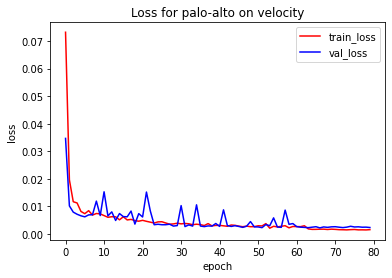

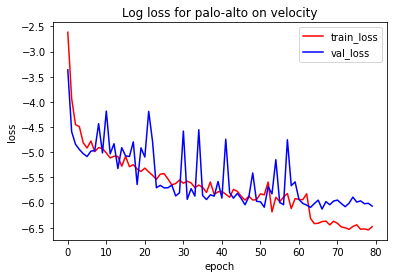

Total training time is: 9m 35s for palo-alto
CPU times: total: 28min 53s
Wall time: 2h 33min 55s


In [26]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')
    val_dataset = ArgoverseDataset(city, 'val')


    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)
    
    X_val_nn_pos = val_dataset.nn_pos_inputs.to(device)
    y_val_nn_pos = val_dataset.nn_pos_outputs.to(device)
    X_val_nn_velo = val_dataset.nn_velo_inputs.to(device)
    y_val_nn_velo = val_dataset.nn_velo_outputs.to(device)
    X_val = val_dataset.input_positions.to(device)
    y_val = val_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=50,
        output_size=2,
        hidden_size=128,
        num_layers=1,
        dropout=0.
    )

    nn_pos.to(device)

    train_losses_pos, val_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=100,
        target_len=1,
        batch_size=128,
        patience = 5,
        threshold = 1e-3,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        early_stop_criteria = 10,
        device=device,
        model_type='pos'
    )


    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.plot(val_losses_pos, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_pos), color="red", label="train_loss")
    plt.plot(np.log(val_losses_pos), color="blue", label="val_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=49,
        output_size=2,
        hidden_size=512,
        num_layers=1,
        dropout=0.
    )

    nn_velo.to(device)

    train_losses_velo, val_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        X_val_nn_velo,
        y_val_nn_velo,
        n_epochs=120,
        target_len=59,
        batch_size=128,
        patience = 10,
        threshold = 1e-4,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        early_stop_criteria = 12,
        device=device,
        model_type='velo'
    )

    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.plot(val_losses_velo, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_velo), color="red", label="train_loss")
    plt.plot(np.log(val_losses_velo), color="blue", label="val_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

Training austin


  2%|▏         | 20/1000 [00:32<26:27,  1.62s/it, loss=0.16053] 

Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.


  5%|▌         | 52/1000 [01:24<24:27,  1.55s/it, loss=0.00198]

Epoch 00052: reducing learning rate of group 0 to 1.0000e-05.


 16%|█▌        | 160/1000 [04:25<22:07,  1.58s/it, loss=0.00006]

Epoch 00160: reducing learning rate of group 0 to 1.0000e-06.


 27%|██▋       | 267/1000 [07:18<19:15,  1.58s/it, loss=0.00003]

Epoch 00267: reducing learning rate of group 0 to 1.0000e-07.


 30%|███       | 300/1000 [08:12<20:44,  1.78s/it, loss=0.00004]

Epoch 00300: reducing learning rate of group 0 to 1.0000e-08.


 34%|███▎      | 337/1000 [09:16<18:15,  1.65s/it, loss=0.00004]

Stopped early at epoch 337 due to overfit


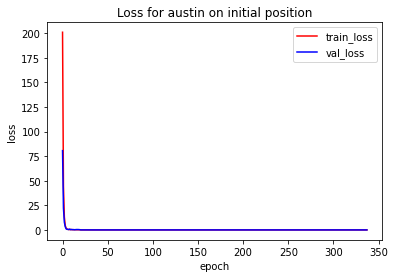

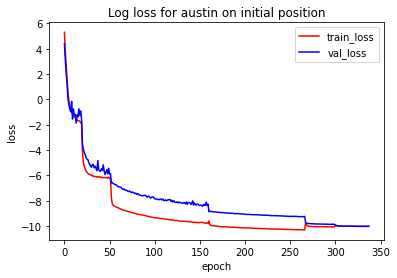

Total training time is: 9m 16s for austin
Training miami


  2%|▏         | 20/1000 [00:42<36:01,  2.21s/it, loss=0.08847]

Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.


  5%|▌         | 50/1000 [01:44<33:22,  2.11s/it, loss=0.00127]

Epoch 00050: reducing learning rate of group 0 to 1.0000e-05.


 14%|█▍        | 141/1000 [04:54<32:54,  2.30s/it, loss=0.00006]

Epoch 00141: reducing learning rate of group 0 to 1.0000e-06.


 19%|█▉        | 189/1000 [06:35<28:16,  2.09s/it, loss=0.00006]

Epoch 00189: reducing learning rate of group 0 to 1.0000e-07.


 24%|██▎       | 237/1000 [08:14<26:34,  2.09s/it, loss=0.00008]

Epoch 00237: reducing learning rate of group 0 to 1.0000e-08.


 27%|██▋       | 270/1000 [09:25<25:27,  2.09s/it, loss=0.00008]

Stopped early at epoch 270 due to overfit


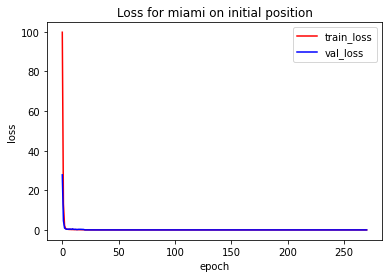

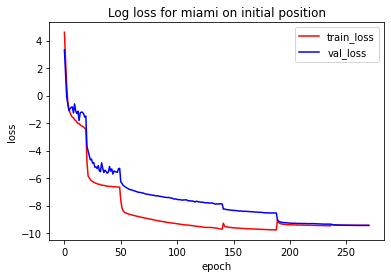

Total training time is: 9m 25s for miami
Training pittsburgh


  2%|▎         | 25/1000 [00:40<25:54,  1.59s/it, loss=0.07489] 

Epoch 00025: reducing learning rate of group 0 to 1.0000e-04.


  5%|▌         | 52/1000 [01:26<28:40,  1.82s/it, loss=0.00112]

Epoch 00052: reducing learning rate of group 0 to 1.0000e-05.


 19%|█▉        | 192/1000 [05:23<23:05,  1.72s/it, loss=0.00005]

Epoch 00192: reducing learning rate of group 0 to 1.0000e-06.


 23%|██▎       | 226/1000 [06:20<21:55,  1.70s/it, loss=0.00005]

Epoch 00226: reducing learning rate of group 0 to 1.0000e-07.


 24%|██▍       | 245/1000 [06:52<21:19,  1.69s/it, loss=0.00006]

Epoch 00245: reducing learning rate of group 0 to 1.0000e-08.


 28%|██▊       | 275/1000 [07:47<20:32,  1.70s/it, loss=0.00006]

Stopped early at epoch 275 due to overfit


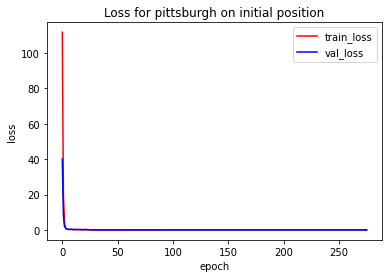

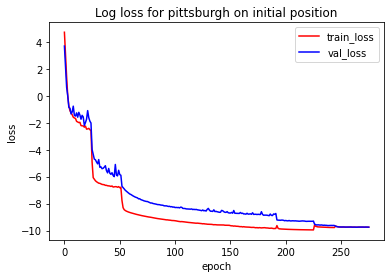

Total training time is: 7m 47s for pittsburgh
Training dearborn


  2%|▏         | 24/1000 [00:21<14:34,  1.12it/s, loss=0.32031] 

Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.


  5%|▍         | 46/1000 [00:42<15:21,  1.03it/s, loss=0.00452]

Epoch 00046: reducing learning rate of group 0 to 1.0000e-05.


 10%|█         | 100/1000 [01:34<13:46,  1.09it/s, loss=0.00019]

Epoch 00100: reducing learning rate of group 0 to 1.0000e-06.


 23%|██▎       | 231/1000 [03:35<11:51,  1.08it/s, loss=0.00010]

Epoch 00231: reducing learning rate of group 0 to 1.0000e-07.


 27%|██▋       | 274/1000 [04:14<11:00,  1.10it/s, loss=0.00011]

Epoch 00274: reducing learning rate of group 0 to 1.0000e-08.


 31%|███       | 306/1000 [04:44<10:45,  1.08it/s, loss=0.00011]

Stopped early at epoch 306 due to overfit


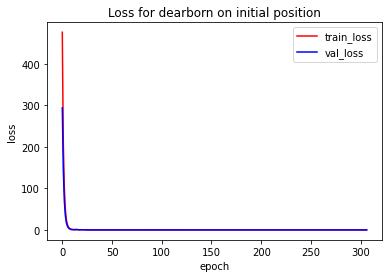

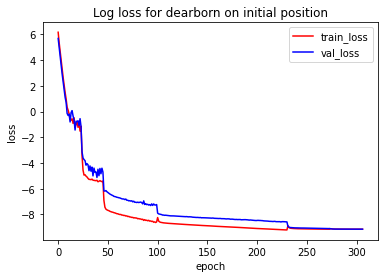

Total training time is: 4m 44s for dearborn
Training washington-dc


  3%|▎         | 34/1000 [00:33<15:33,  1.04it/s, loss=0.10570] 

Epoch 00034: reducing learning rate of group 0 to 1.0000e-04.


  7%|▋         | 73/1000 [01:13<16:21,  1.06s/it, loss=0.00172]

Epoch 00073: reducing learning rate of group 0 to 1.0000e-05.


 27%|██▋       | 271/1000 [04:27<11:53,  1.02it/s, loss=0.00004]

Epoch 00271: reducing learning rate of group 0 to 1.0000e-06.


 29%|██▊       | 286/1000 [04:41<11:50,  1.00it/s, loss=0.00002]

Epoch 00286: reducing learning rate of group 0 to 1.0000e-07.


 30%|██▉       | 298/1000 [04:53<11:38,  1.01it/s, loss=0.00003]

Epoch 00298: reducing learning rate of group 0 to 1.0000e-08.


 34%|███▎      | 336/1000 [05:30<10:52,  1.02it/s, loss=0.00003]

Stopped early at epoch 336 due to overfit


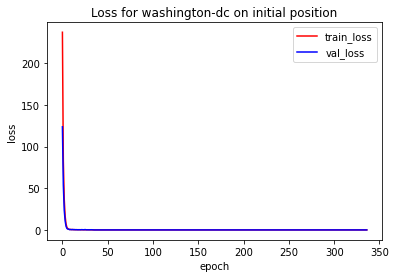

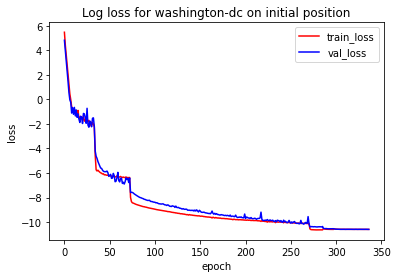

Total training time is: 5m 30s for washington-dc
Training palo-alto


  4%|▍         | 43/1000 [00:19<06:51,  2.32it/s, loss=0.35162] 

Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.


  9%|▉         | 93/1000 [00:41<06:41,  2.26it/s, loss=0.00729]

Epoch 00093: reducing learning rate of group 0 to 1.0000e-05.


 20%|██        | 202/1000 [01:31<06:39,  2.00it/s, loss=0.00026]

Epoch 00202: reducing learning rate of group 0 to 1.0000e-06.


 39%|███▉      | 393/1000 [03:00<04:29,  2.25it/s, loss=0.00013]

Epoch 00393: reducing learning rate of group 0 to 1.0000e-07.


 40%|████      | 403/1000 [03:04<04:26,  2.24it/s, loss=0.00013]

Epoch 00403: reducing learning rate of group 0 to 1.0000e-08.


 43%|████▎     | 429/1000 [03:17<04:22,  2.18it/s, loss=0.00013]

Stopped early at epoch 429 due to overfit


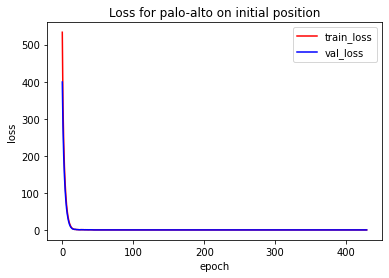

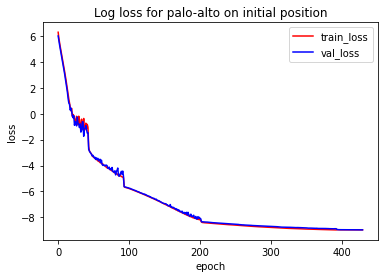

Total training time is: 3m 17s for palo-alto
CPU times: total: 5min 2s
Wall time: 40min 2s


In [36]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')
    val_dataset = ArgoverseDataset(city, 'val')


    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)
    
    X_val_nn_pos = val_dataset.nn_pos_inputs.to(device)
    y_val_nn_pos = val_dataset.nn_pos_outputs.to(device)
    X_val_nn_velo = val_dataset.nn_velo_inputs.to(device)
    y_val_nn_velo = val_dataset.nn_velo_outputs.to(device)
    X_val = val_dataset.input_positions.to(device)
    y_val = val_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=50,
        output_size=2,
        hidden_size=128,
        num_layers=1,
        dropout=0.
    )

    nn_pos.to(device)

    train_losses_pos, val_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=1000,
        target_len=1,
        batch_size=128,
        patience = 5,
        threshold = 1e-3,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        early_stop_criteria = 10,
        device=device,
        model_type='pos'
    )


    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.plot(val_losses_pos, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_pos), color="red", label="train_loss")
    plt.plot(np.log(val_losses_pos), color="blue", label="val_loss")
    plt.legend()
    plt.show()



    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

### Generate CSV

In [73]:
num_layers_pos = 1
num_layers_velo = 1
batch_size = 128

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')

    X_test_nn_pos = test_dataset.nn_pos_inputs.to(device)
    X_test_nn_velo = test_dataset.nn_velo_inputs.to(device)
    center_test = test_dataset.center.to(device)

    otuputs = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_atten_100_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_atten_' + str(num_layers_velo) + '_' + city, 'rb'))
    model_pos.eval()
    model_velo.eval()

    n_batches_test = int(X_test_nn_pos.shape[0] / batch_size)
    last_batch_size = X_test_nn_pos.shape[0] % batch_size

    for b in range(n_batches_test):
        # select data
        input_batch_pos = X_test_nn_pos[b: b + batch_size, :, :]
        input_batch_velo = X_test_nn_velo[b: b + batch_size, :, :]

        # outputs tensor
        outputs_pos = torch.zeros(batch_size, 1, input_batch_pos.shape[2]).to(device)
        outputs_velo = torch.zeros(batch_size, 1, input_batch_velo.shape[2]).to(device)

        # encoder outputs
        encoder_output_pos, concat_hidden_pos = model_pos.encoder(input_batch_pos)
        encoder_output_velo, concat_hidden_velo = model_velo.encoder(input_batch_velo)

        # decoder with teacher forcing
        # shape: (batch_size, input_size)
        decoder_input_pos = input_batch_pos[:, -1, :]
        decoder_hidden_pos = concat_hidden_pos




        for t in range(target_len):
            decoder_hidden = (decoder_hidden[0].squeeze(0), decoder_hidden[1].squeeze(0))
            # print(decoder_input.squeeze().shape)
            # print(decoder_hidden[0].shape)
            decoder_output, decoder_hidden = model.attn_decoder(decoder_input.squeeze(), decoder_hidden, encoder_output)
            outputs[:, t, :] = decoder_output
            
            if random.random() < teacher_forcing_ratio: 
                decoder_input = target_batch[:, t, :]
            else: 
                decoder_input = decoder_output
nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
nn_pos_nth_input = nn_pos_nth_input.to(device)
nn_velo_nth_input = nn_velo_nth_input.to(device)
center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder_no_early.predict_1(model_pos, nn_pos_nth_input, 1, device=device)
        print(init_pos)
        deltas = lstm_encoder_decoder_no_early.predict_n(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)


h.shape: torch.Size([1, 128])
x.shape: torch.Size([1, 2])
tensor([[-40.4635,  12.8427]], device='cuda:0')
h.shape: torch.Size([1, 512])
x.shape: torch.Size([1, 2])
h.shape: torch.Size([512, 1])
x.shape: torch.Size([1, 1, 2])
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Sirui Tao\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Sirui Tao\AppData\Local\Temp\ipykernel_16196\2888141495.py", line 21, in <cell line: 7>
    deltas = lstm_encoder_decoder_no_early.predict_n(model_velo, nn_velo_nth_input, 59, device=device)
  File "c:\dev\UCSD\UCSD_CSE151B_Kaggle\argo2\seq2seq_lstm\lstm_encoder_decoder_no_early.py", line 149, in predict_n
    decoder_output, decoder_hidden = model.attn_decoder(decoder_input.unsqueeze(0), decoder_hidden, encoder_output.unsqueeze(0))
  File "c:\Users\Sirui Tao\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "c:\dev\UCSD\UCSD_CSE151B_Kaggle\argo2\seq2seq_lstm\lstm_encoder_decoder_no_early.py", line 40, in forward
    attn_weights = 

In [67]:
all_predictions.to_csv('two_lstm_enc_dec_out_5.csv', index=False)

NameError: name 'all_predictions' is not defined